# Country Graph
- Created a graph with 249 nodes, each representing a country (non-UN-recognized and technically unofficial countries were also included for increased faithfulness to the original game)

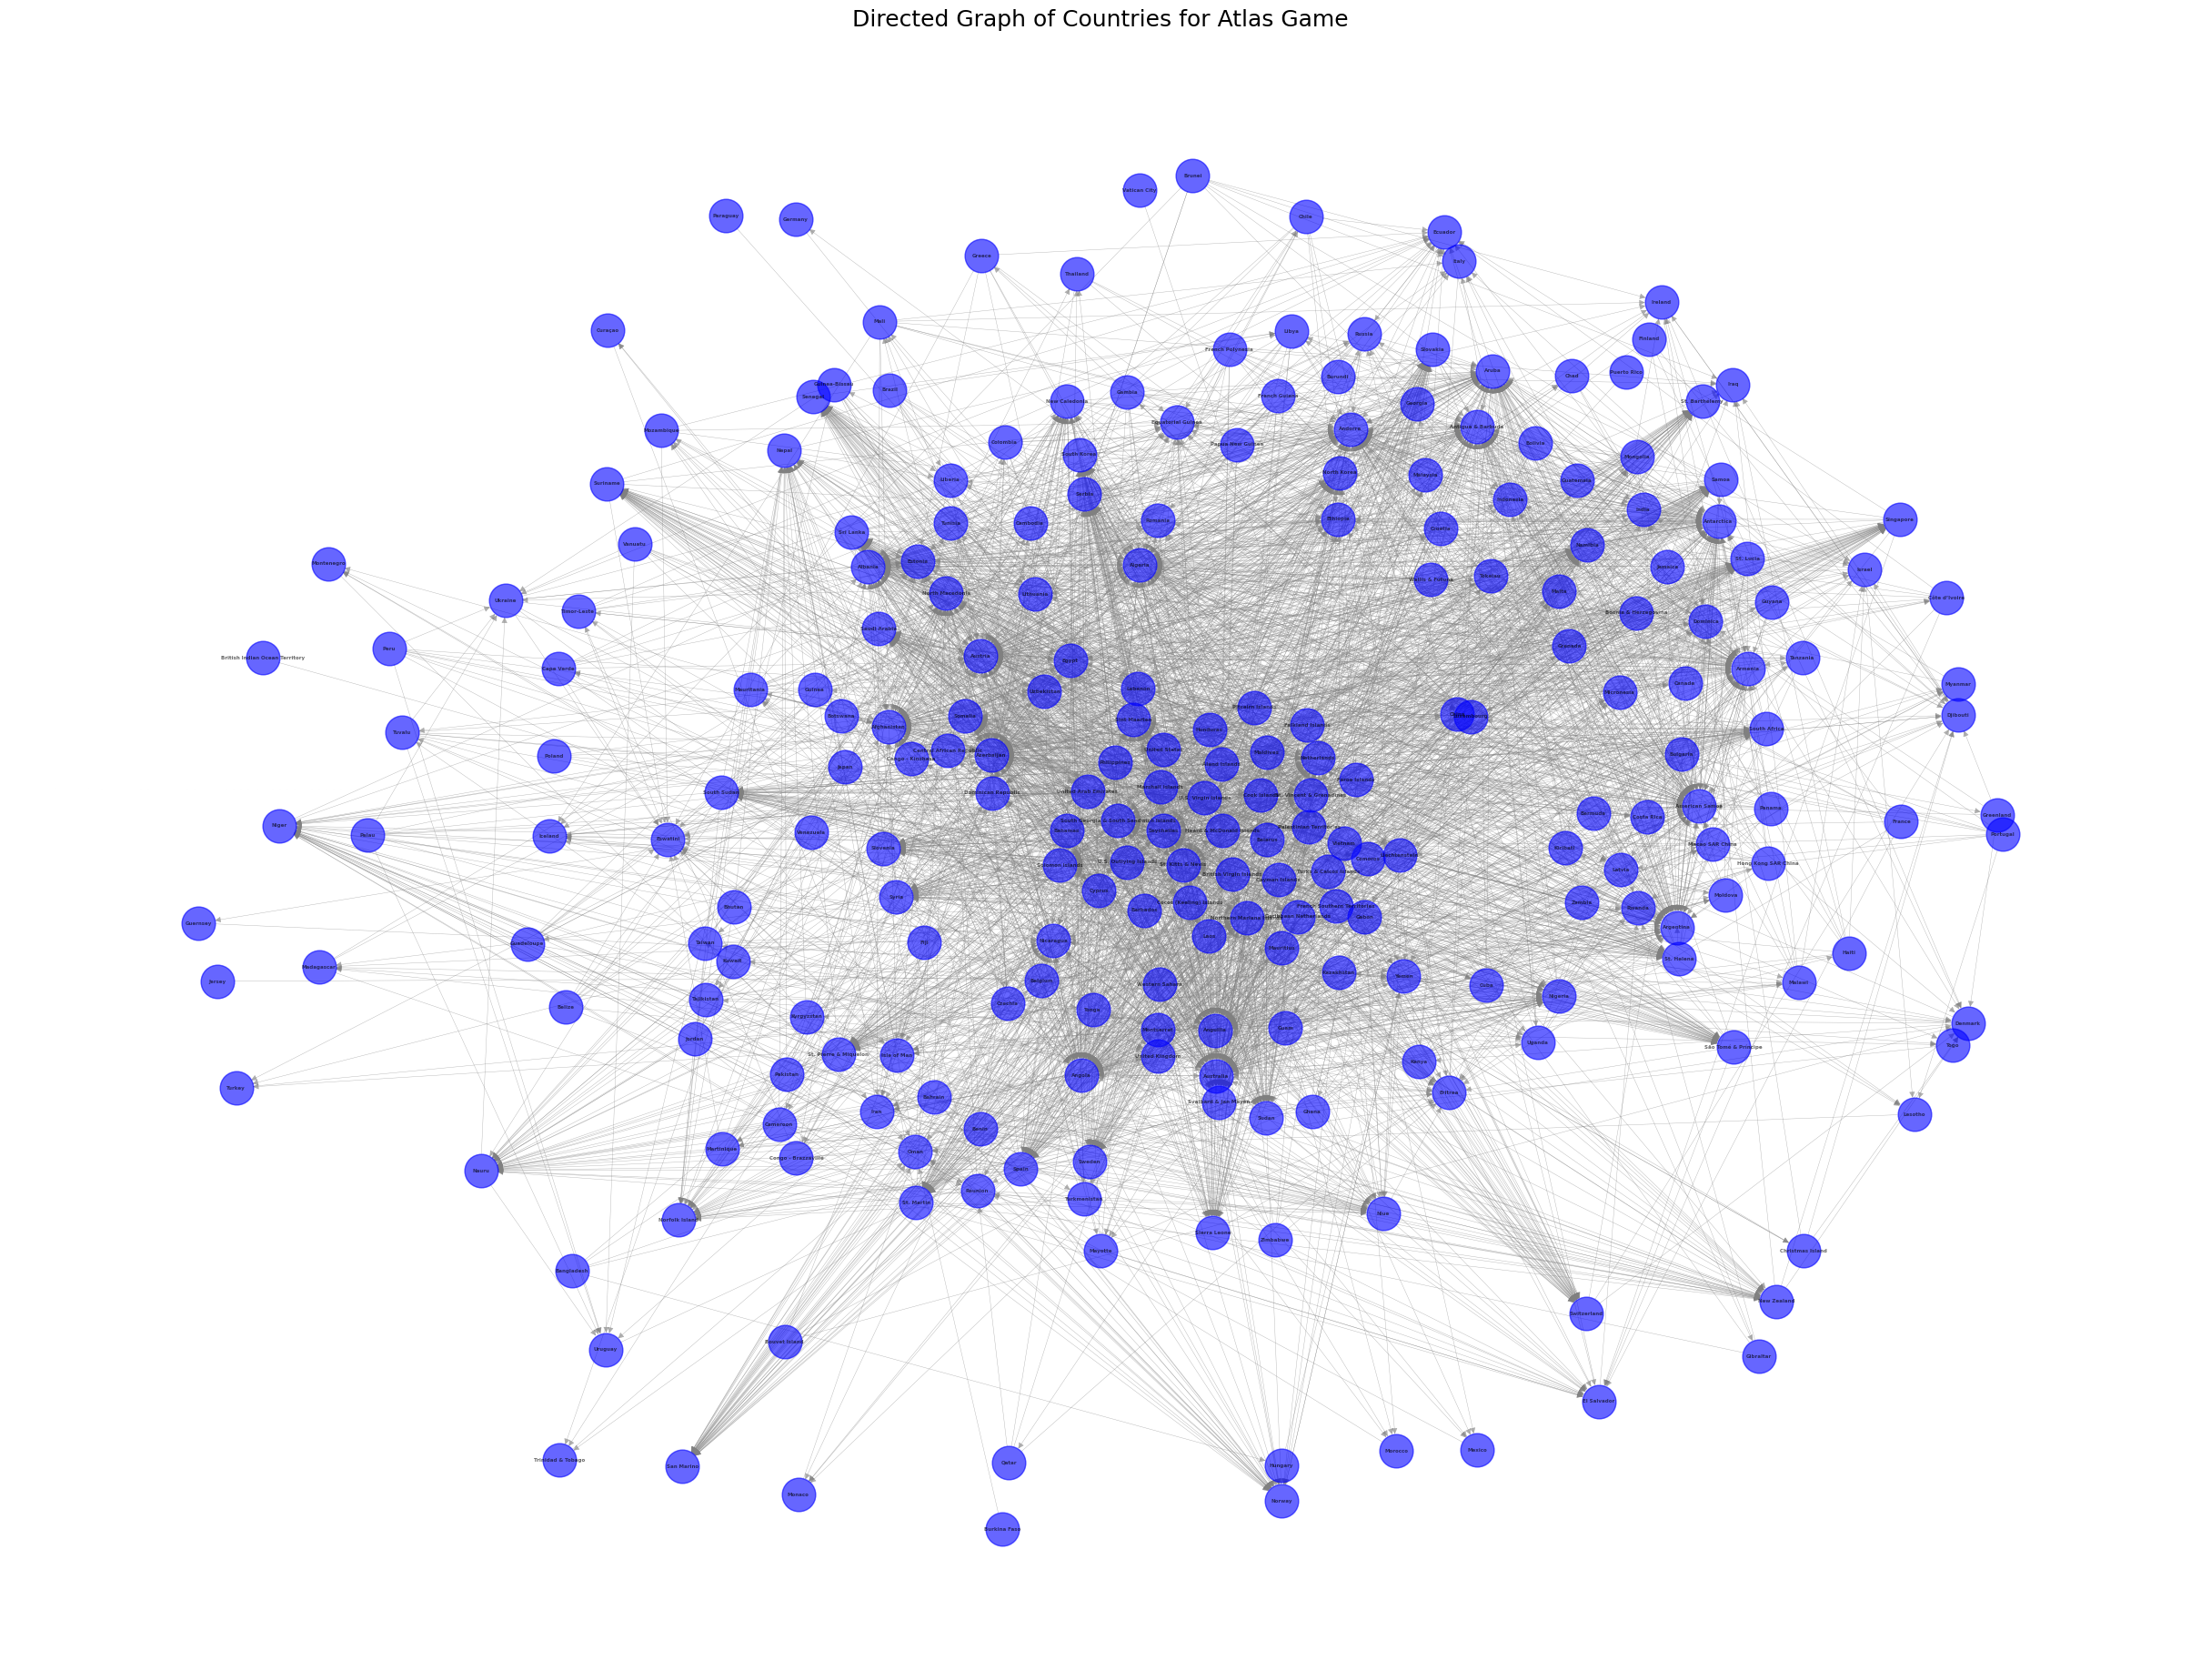

Number of nodes: 249
Number of edges: 3566


In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import random

# Load country data
file_path = 'country.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Extract country codes and names
countries = df.set_index('value')['id'].to_dict()

# Create a directed graph
G = nx.DiGraph()
# Add edges based on the Atlas game rule
for country, code in countries.items():
    last_letter = country[-1].lower()
    for other_country, other_code in countries.items():
        if other_country[0].lower() == last_letter and country != other_country:
            # G.add_edge(code, other_code)
            G.add_edge(country, other_country)

# Plot the graph
plt.figure(figsize=(24, 18))  # Increase figure size for better visibility
pos = nx.fruchterman_reingold_layout(G, k=0.9, seed=42)  # Fruchterman-Reingold for better spacing
nx.draw(
    G, pos, with_labels=True, node_size=700, node_color='blue', 
    edge_color='gray', font_size=4, font_weight='bold', width=0.3, alpha=0.6
)
plt.title('Directed Graph of Countries for Atlas Game', fontsize=18)
plt.show()

# Basic graph information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


# Monte Carlo Tree Search
- Used MCTS to find the next possible best move from a starting country.
- Given the state of the graph (with appropriate book keeping of the visited nodes) at any point of time during the game, and given around 16.67 minutes (more like 18 with this potato laptop), we can determine the (possibly) next most optimal move which would statistically lead to the most number of victories on average.
- Basically ran a brute force 1000-iteration for loop over the 5000 iteration MCTS simulation on the graph to count the frequency of the wins from each possible optimal move generated from the MCTS as the results were fairly inconclusive for some countries like Japan.
- Taking the case of Japan, let's assume we start the game at Japan. There are fifteen possible moves from Japan (15 countries beginning with the letter 'N'). So if they were all equally likely to lead to victory, then theoretically over 1000 iterations of a game simulation starting from Japan, each of these 15 countries would have around 67 wins associated with it (1000/15). However, as I saw from the frequency count of the wins after performing 1000 5000-iteration MCTS runs, the objectively best move from Japan would be the Northern Mariana Islands.
- Expert domain knowledge and optimal gameplay of opponent was NOT taken into consideration during the MCTS.
- Theoretically this could give us a game that is as very close to optimal given a starting country and enough time. To test this theory, i put Yemen as the starting country, knowing for a fact that the optimal move from here would be Norway. Sure enough, that was the city with the highest win rate.

In [ ]:
class AtlasGameState:
    def __init__(self, graph, current_country, player=0, visited=None):
        self.graph = graph
        self.current_country = current_country
        self.player = player
        # Track visited countries to avoid cycles
        if visited is None:
            visited = set()
        self.visited = visited

    def get_available_moves(self):
        possible_moves = list(self.graph.successors(self.current_country))
        # Filter out already visited countries
        return [m for m in possible_moves if m not in self.visited]

    def is_terminal(self):
        return len(self.get_available_moves()) == 0

    def make_move(self, next_country):
        new_visited = set(self.visited)
        new_visited.add(next_country)
        return AtlasGameState(
            graph=self.graph,
            current_country=next_country,
            player=(1 - self.player),
            visited=new_visited
        )

    def is_win(self):
        # If no moves available, current player loses => other player wins
        return False

    def clone(self):
        return AtlasGameState(
            self.graph,
            self.current_country,
            self.player,
            set(self.visited)
        )

# DEFINING THE MCTS NODE
class MCTSNode:
    def __init__(self, state, parent=None, move=None):
        self.state = state
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.wins = 0

    def expand(self):
        if not self.children:
            for move in self.state.get_available_moves():
                new_state = self.state.make_move(move)
                self.children.append(MCTSNode(state=new_state, parent=self, move=move))

    def select_child(self, c_param=1.4):
        best_child, best_score = None, -float("inf")
        for child in self.children:
            win_rate = child.wins / (child.visits + 1e-9)
            uct_score = win_rate + c_param * math.sqrt(
                math.log(self.visits + 1) / (child.visits + 1e-9)
            )
            if uct_score > best_score:
                best_score = uct_score
                best_child = child
        return best_child

    def simulate(self):
        tmp_state = self.state.clone()
        current_player = tmp_state.player
        while not tmp_state.is_terminal():
            moves = tmp_state.get_available_moves()
            tmp_state = tmp_state.make_move(random.choice(moves))
        # If terminal reached, the current tmp_state player is the one who can't move, so the other wins
        return 1 if tmp_state.player != current_player else 0

    def backpropagate(self, result):
        self.visits += 1
        self.wins += result
        if self.parent:
            self.parent.backpropagate(result)

# MCTS SEARCH FUNCTION
def mcts_search(root_state, iterations=1000):
    root_node = MCTSNode(root_state)
    for i in range(iterations):
        # Optional progress tracking
        if i % 100 == 0:
            # print(f"Iteration {i}/{iterations}")
            pass

        node = root_node
        # Selection
        while node.children and not node.state.is_terminal():
            node = node.select_child()
        # Expansion
        if not node.children and not node.state.is_terminal():
            node.expand()
            if node.children:
                node = random.choice(node.children)
        # Simulation
        result = node.simulate()
        # Backpropagation
        node.backpropagate(result)

    return root_node

# -----------------------------
# Run MCTS from a chosen start country
# -----------------------------
start_country = 'Japan'  # Replace with a valid node in your graph
root_state = AtlasGameState(G, start_country, player=0, visited={start_country})

# -----------------------------
# Output best moves and winning rates
# -----------------------------
win_dic={}
for i in range(1000):
    root_node = mcts_search(root_state, iterations=5000)
    if not root_node.children:
        print(f"No moves available from {start_country}. Terminal state.")
    else:
        children_sorted = sorted(
            root_node.children,
            key=lambda c: c.wins / (c.visits + 1e-9),
            reverse=True
        )
        print(f"Possible moves from {start_country}:")
        for child in children_sorted:
            move_country = child.move
            win_rate = child.wins / (child.visits + 1e-9)
            print(f"  Move to {move_country}: visits={child.visits}, win_rate={win_rate:.2f}")

        best_move = children_sorted[0].move
        if win_dic.get(best_move)==None:
            win_dic[best_move]=1
        else:
            win_dic[best_move]+=1
        print(f"\nBest Move from {start_country} is to: {best_move}")
print(win_dic)

Possible moves from Japan:
  Move to Norway: visits=542, win_rate=0.55
  Move to Niger: visits=506, win_rate=0.54
  Move to Nigeria: visits=409, win_rate=0.52
  Move to Norfolk Island: visits=374, win_rate=0.51
  Move to North Macedonia: visits=358, win_rate=0.51
  Move to Nauru: visits=346, win_rate=0.51
  Move to New Caledonia: visits=341, win_rate=0.50
  Move to Nepal: visits=333, win_rate=0.50
  Move to Namibia: visits=322, win_rate=0.50
  Move to Northern Mariana Islands: visits=284, win_rate=0.48
  Move to North Korea: visits=279, win_rate=0.48
  Move to New Zealand: visits=252, win_rate=0.47
  Move to Nicaragua: visits=247, win_rate=0.47
  Move to Niue: visits=237, win_rate=0.46
  Move to Netherlands: visits=170, win_rate=0.41

Best Move from Japan is to: Norway
Possible moves from Japan:
  Move to North Korea: visits=622, win_rate=0.56
  Move to Nauru: visits=449, win_rate=0.53
  Move to New Zealand: visits=393, win_rate=0.52
  Move to Niue: visits=377, win_rate=0.51
  Move to 

# Random Game Simulation and Other Helper Functions
- Made a very basic helper function to simulate a game between non-experts to help me analyze the graph at different points of time.

In [3]:
from collections import defaultdict, Counter
import random

def compute_ending_letter_centrality(out_degree_dict):
    letter_ctr = Counter()
    for country, val in out_degree_dict.items():
        last_letter = country[-1].lower()
        letter_ctr[last_letter] += val
    return letter_ctr

def simulate_game_with_letter_centrality(G, start_country='Iran', N=50, sample_interval=10):
    import copy
    # Work on a copy of the original graph so we don't destroy it
    graph_copy = copy.deepcopy(G)

    current = start_country
    letter_data = defaultdict(list)
    time_points = []

    for move_index in range(N + 1):
        # Recompute out-degree centrality after removing visited node
        out_degree_centrality = nx.out_degree_centrality(graph_copy)
        current_letter_centrality = compute_ending_letter_centrality(out_degree_centrality)

        # Sample at each interval
        if move_index % sample_interval == 0:
            time_points.append(move_index)
            for letter, value in current_letter_centrality.items():
                letter_data[letter].append(value)

        # Find successors; if none, game ends
        if current not in graph_copy.nodes:
            break
        successors = list(graph_copy.successors(current))
        if not successors:
            break

        # Randomly pick a successor
        next_country = random.choice(successors)

        # Remove the current node from graph to avoid reuse
        graph_copy.remove_node(current)

        # Move on
        current = next_country

    return letter_data, time_points

# Out-Degree Centrality
- I think this graph property speaks for itself. Studying which nodes have more options available to them tells us which countries to steer our turns towards to have the most versatile options available
- Picked this property to analyze escape potential

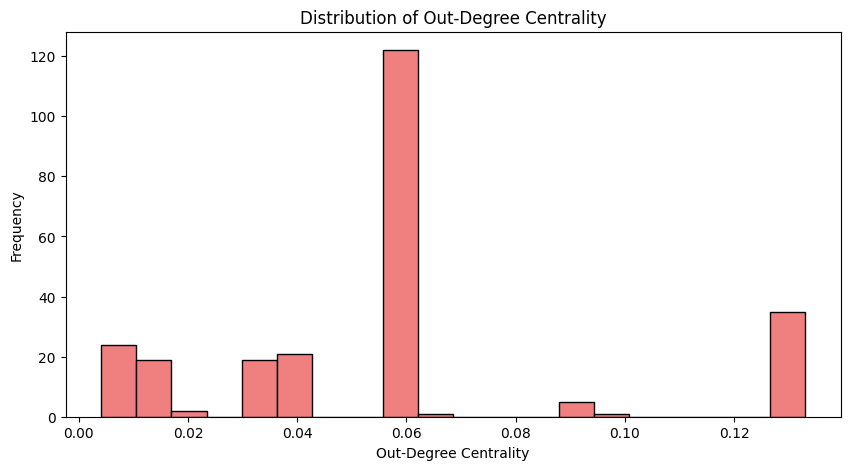

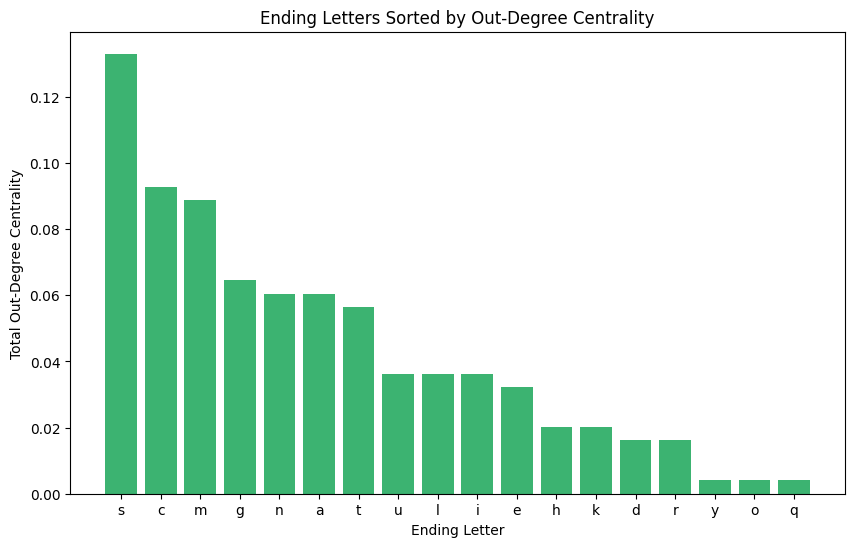

Countries with high out-degree (safe moves with many options):
['Netherlands', 'Northern Mariana Islands', 'Åland Islands', 'Seychelles', 'Solomon Islands', 'South Georgia & South Sandwich Islands', 'St. Kitts & Nevis', 'St. Vincent & Grenadines', 'Bahamas', 'Heard & McDonald Islands', 'Honduras', 'Barbados', 'Belarus', 'Maldives', 'Marshall Islands', 'Mauritius', 'Laos', 'British Virgin Islands', 'Caribbean Netherlands', 'Cayman Islands', 'Cocos (Keeling) Islands', 'Comoros', 'Cook Islands', 'Cyprus', 'Turks & Caicos Islands', 'Falkland Islands', 'Faroe Islands', 'French Southern Territories', 'U.S. Outlying Islands', 'U.S. Virgin Islands', 'United Arab Emirates', 'United States', 'Palestinian Territories', 'Philippines', 'Pitcairn Islands']

Countries with low out-degree (trap opponents here):
['Norway', 'San Marino', 'St. Barthélemy', 'Hungary', 'Mexico', 'Monaco', 'Montenegro', 'Morocco', 'Lesotho', 'British Indian Ocean Territory', 'Iraq', 'Italy', 'Burkina Faso', 'Curaçao', 'Togo

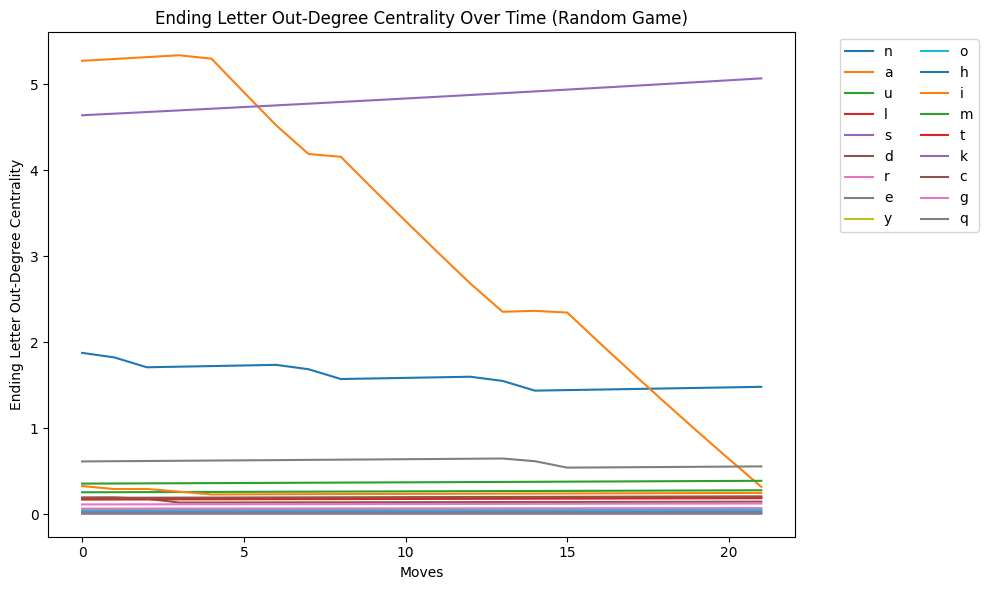

In [53]:
from collections import Counter

# Compute out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)

# Sort nodes by out-degree centrality
sorted_out_degree = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Visualize entire out-degree centrality distribution
plt.figure(figsize=(10, 5))
plt.hist(list(out_degree_centrality.values()), bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Out-Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Out-Degree Centrality')
plt.show()

# Analyze ending letter by out-degree centrality
ending_letter_centrality = Counter()
for country, centrality in out_degree_centrality.items():
    # print(country,centrality)
    last_letter = country[-1].lower()
    ending_letter_centrality[last_letter] = centrality

# Sort and plot ending letters by centrality
sorted_letters = sorted(ending_letter_centrality.items(), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10, 6))
plt.bar([letter for letter, _ in sorted_letters], [value for _, value in sorted_letters], color='mediumseagreen')
plt.xlabel('Ending Letter')
plt.ylabel('Total Out-Degree Centrality')
plt.title('Ending Letters Sorted by Out-Degree Centrality')
plt.show()

# Actionable insights for the game
high_degree_nodes = [node for node, centrality in out_degree_centrality.items() if centrality > 0.1]
low_degree_nodes = [node for node, centrality in out_degree_centrality.items() if centrality < 0.01]

print("Countries with high out-degree (safe moves with many options):")
print(high_degree_nodes)
print("\nCountries with low out-degree (trap opponents here):")
print(low_degree_nodes)

# Recommend a strategic move
def recommend_move(current_country):
    if current_country in out_degree_centrality:
        successors = list(G.successors(current_country))
        best_move = min(successors, key=lambda x: out_degree_centrality.get(x, 0)) if successors else None
        return best_move
    return None

current_country = 'Iran'  # Example starting country
best_next_move = recommend_move(current_country)
print(f"Best move from {current_country}: {best_next_move}")

letter_data, time_samples = simulate_game_with_letter_centrality(G, start_country='Iran', N=100, sample_interval=1)

plt.figure(figsize=(10, 6))
for letter, values in letter_data.items():
    plt.plot(time_samples, values, label=letter)
plt.xlabel('Moves')
plt.ylabel('Ending Letter Out-Degree Centrality')
plt.title('Ending Letter Out-Degree Centrality Over Time (Random Game)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()


### ACTIONABLE INSIGHTS- Why is Norway the best move from Iran?
- For all the countries beginning with N, those ending with Y have the lowest out-degree centrality, meaning, your opponent now has the greatest possible reduction in available moves.
- Say instead of a country like Norway, we said Northern Mariana Islands instead. Now, our opponent has 33 countries beginning with S to choose from instead of one singular country starting with Y (assuming of course, these countries have not been mentioned yet).
- By logical extension, it stands to reason that the best possible move to play at any given time (given that we are only using countries) would be a country ending with Y, such as Turkey, Uruguay, Paraguay, St. Barthélemy, etc, as this guarantees a win for whoever uses the second country beginning with a Y after the game starts. This is a direct result of Yemen being the sole country beginning with a Y.

# Betweenness Centrality
- Countries with high betweenness centrality act as critical "choke points" in the game. Controlling these nodes allows you to restrict your opponent's movement and force them into disadvantageous positions.
- Betweenness centrality in essence just indicates how often a node lies on the shortest paths between other nodes in a network.
- The importance of studying this parameter of the graph draws directly from the previous conclusions we drew about forcing your opponent into having to name a country starting with a Y. Among the countries ending with the letter Y, the ones with a higher betweenness centrality are more likely to be named first, as from any arbitrary country, the shortest path to, say, Yemen, would be through a node with a higher betweenness centrality (on average, statistically).
- When it comes to manipulating an opponent's moves, direct the opponent towards low betweenness countries to limit their available options and gradually push them towards terminal states.
- Picked this property to study choke point control

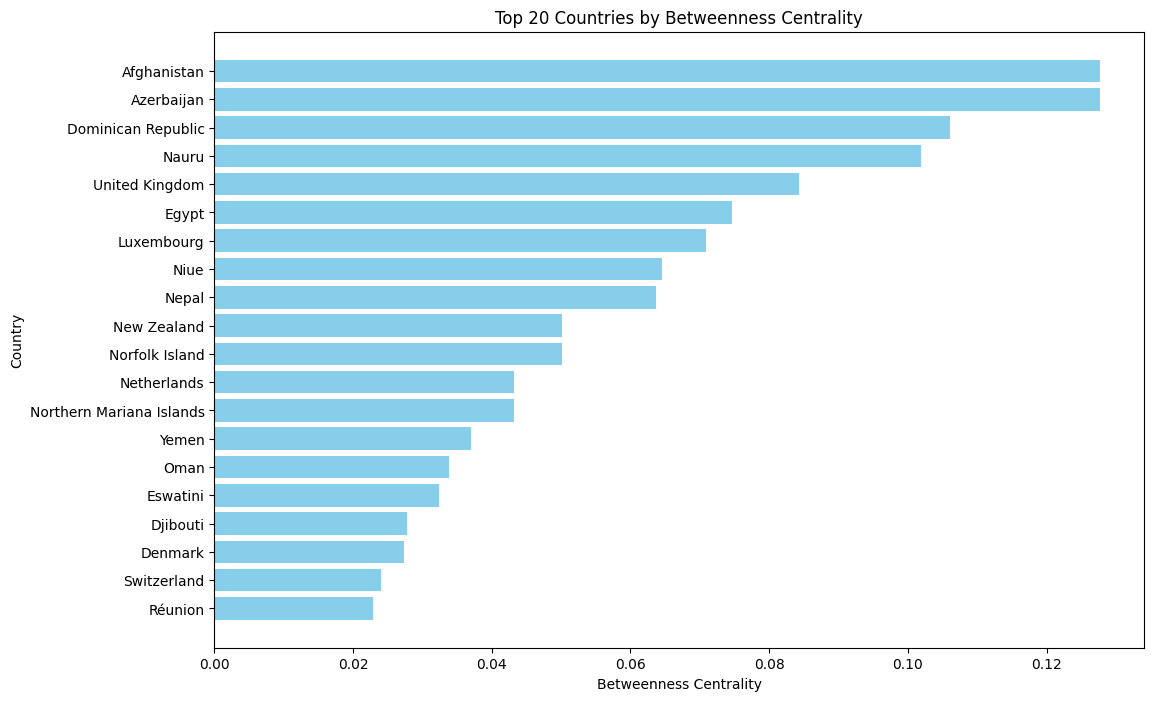

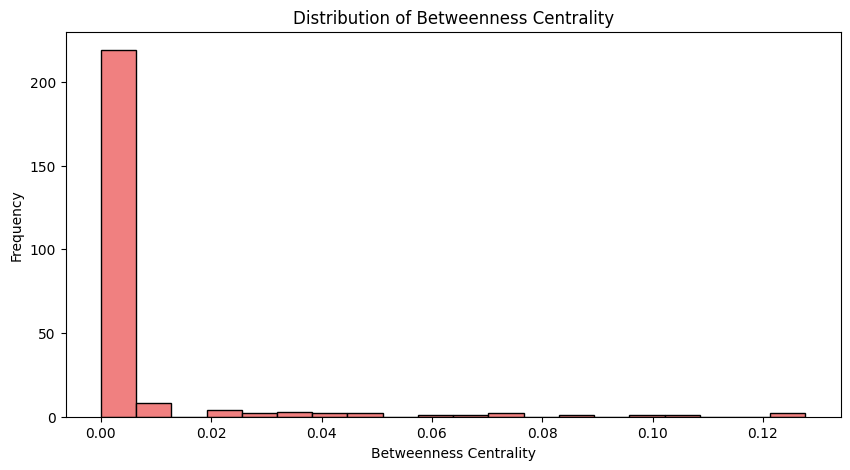

Countries with high betweenness (key strategic control points):
['Afghanistan', 'Nauru', 'Azerbaijan', 'Dominican Republic']

Countries with low betweenness (less critical paths):
['Åland Islands', 'Seychelles', 'Solomon Islands', 'South Georgia & South Sandwich Islands', 'St. Kitts & Nevis', 'St. Vincent & Grenadines', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua & Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia & Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Central African Republic', 'Falkland Islands', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Pakistan', 'Palau

In [10]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Sort nodes by betweenness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Visualize top countries by betweenness centrality
plt.figure(figsize=(12, 8))
plt.barh([node for node, _ in sorted_betweenness[:20]], [value for _, value in sorted_betweenness[:20]], color='skyblue')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Country')
plt.title('Top 20 Countries by Betweenness Centrality')
plt.gca().invert_yaxis()
plt.show()

# Visualize the overall betweenness centrality distribution
plt.figure(figsize=(10, 5))
plt.hist(list(betweenness_centrality.values()), bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Betweenness Centrality')
plt.show()

# Actionable insights for the game
high_betweenness_nodes = [node for node, centrality in betweenness_centrality.items() if centrality > 0.1]
low_betweenness_nodes = [node for node, centrality in betweenness_centrality.items() if centrality < 0.00001]

print("Countries with high betweenness (key strategic control points):")
print(high_betweenness_nodes)
print("\nCountries with low betweenness (less critical paths):")
print(low_betweenness_nodes)

# Strategic move recommendation based on betweenness

def recommend_strategic_move(current_country):
    if current_country in betweenness_centrality:
        successors = list(G.successors(current_country))
        if not successors:
            return None
        best_move = max(successors, key=lambda x: betweenness_centrality.get(x, 0))
        return best_move
    return None

current_country = 'India'  # Example starting country
best_strategic_move = recommend_strategic_move(current_country)
print(f"Best strategic move from {current_country}: {best_strategic_move}")


### ACTIONABLE INSIGHTS
- Start by securing countries with high betweenness to maximize influence over available paths.
- If playing defensively, guide the opponent toward low betweenness nodes, gradually reducing their escape options.
- When choosing the next move, prefer countries with moderate betweenness to keep future options open while avoiding over-exposure to critical nodes.
- As we can see pretty evidently and conclusively from the distribution of betweenness centrality in the coral bar graph above, the grand majority of countries (and the highest proportion of countries) are relatively insignificantly important to the overall network, purely because of how many options we have to get to a country.

# CLOSENESS CENTRALITY
- I chose this property to analyze in order to understand move efficiency.
- Countries with high closeness centrality can quickly reach a variety of other countries.

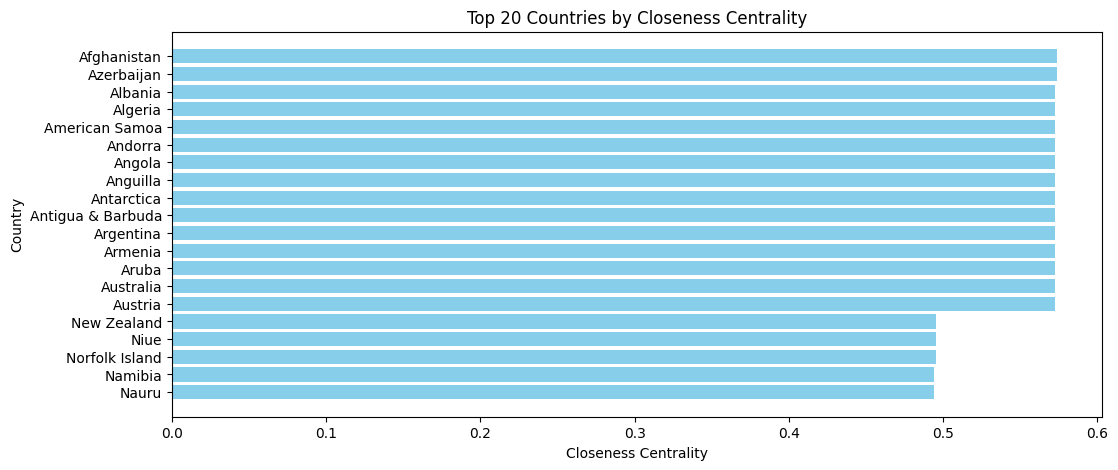

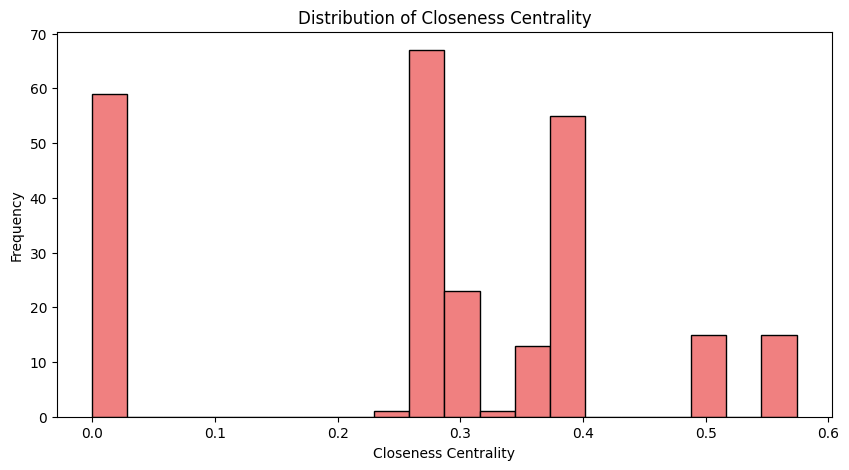

Countries with high closeness (well-connected strategic moves):
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua & Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan']

Countries with low closeness (isolated and potential traps):
['Åland Islands', 'Bahamas', 'Bahrain', 'Bangladesh', 'Haiti', 'Heard & McDonald Islands', 'Honduras', 'Hong Kong SAR China', 'Hungary', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia & Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Falkland Islands', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Pakistan', 'Palau', 'Palestinian Territories', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines'

In [16]:
# Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Sort nodes by closeness centrality
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Visualize top countries by closeness centrality
plt.figure(figsize=(12, 5))
plt.barh([node for node, _ in sorted_closeness[:20]], [value for _, value in sorted_closeness[:20]], color='skyblue')
plt.xlabel('Closeness Centrality')
plt.ylabel('Country')
plt.title('Top 20 Countries by Closeness Centrality')
plt.gca().invert_yaxis()
plt.show()

# Visualize the overall closeness centrality distribution
plt.figure(figsize=(10, 5))
plt.hist(list(closeness_centrality.values()), bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Centrality')
plt.show()

# Actionable insights for the game
high_closeness_nodes = [node for node, centrality in closeness_centrality.items() if centrality > 0.5]
low_closeness_nodes = [node for node, centrality in closeness_centrality.items() if centrality < 0.01]

print("Countries with high closeness (well-connected strategic moves):")
print(high_closeness_nodes)
print("\nCountries with low closeness (isolated and potential traps):")
print(low_closeness_nodes)

# Strategic move recommendation based on closeness

def recommend_efficient_move(current_country):
    if current_country in closeness_centrality:
        successors = list(G.successors(current_country))
        if not successors:
            return None
        best_move = max(successors, key=lambda x: closeness_centrality.get(x, 0))
        return best_move
    return None

current_country = 'India'  # Example starting country
best_efficient_move = recommend_efficient_move(current_country)
print(f"Best efficient move from {current_country}: {best_efficient_move}")


### ACTIONABLE INSIGHTS
- Here we see quite the interesting trend of countries having the same starting letter of A having a higher closeness centrality. This was the obvious result of course, as there are 15 countries starting with A, and quite a significant number of them also end with A (14 out of 15)
- Prioritizing countries with high closeness centrality allows quick movement across the graph, reducing the likelihood of being trapped. So it makes sense early in the game from a flexibility standpoint to use these moves.
- Guide opponents towards low closeness nodes where their future options become limited and harder to escape.

# In-Degree to Out-Degree Ratio
- My personal favourite, the trap potential property
- What you want more than anything in the game of Atlas is to drop a country that's really easy to get to, but near impossible for your opponent to get out of. A quick scan through the list of countries will reveal that there exist a grand total of one country each whose names start with the letters O and Y (Oman and Yemen, the Middle East got tired of losing Atlas I guess).


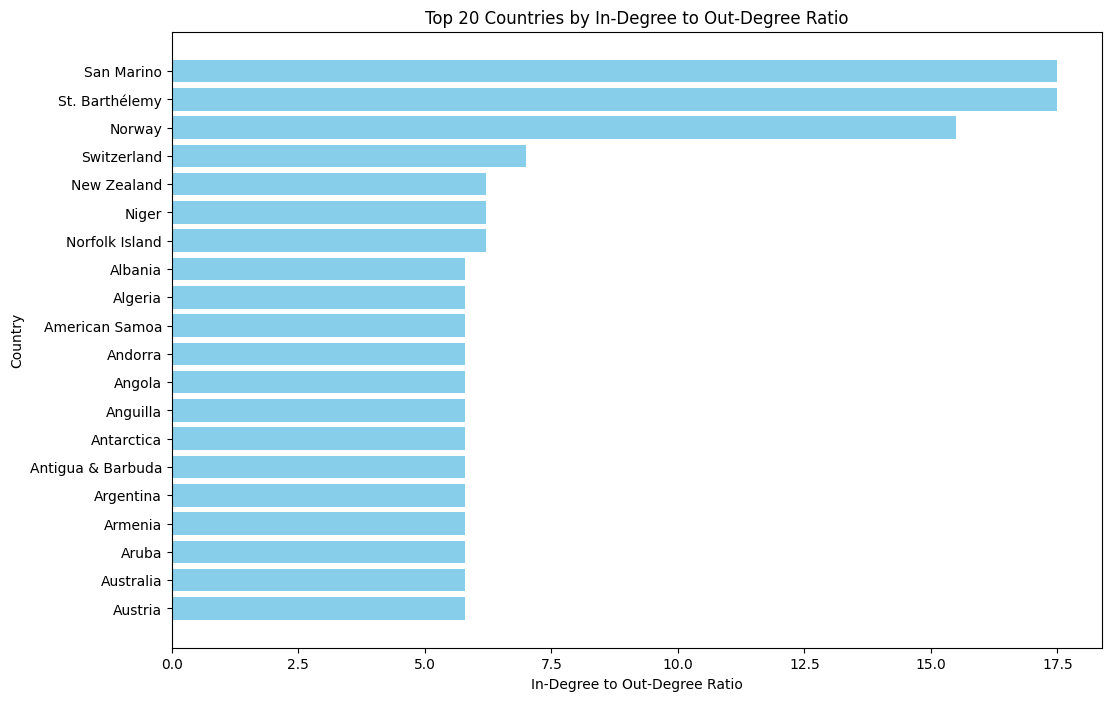

Potential trap countries (high ratio):
['Afghanistan', 'New Zealand', 'Niger', 'Norfolk Island', 'Norway', 'San Marino', 'St. Barthélemy', 'Switzerland', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua & Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan']

Countries with low trap potential:
['Åland Islands', 'Bahamas', 'Bahrain', 'Bangladesh', 'Haiti', 'Heard & McDonald Islands', 'Honduras', 'Hong Kong SAR China', 'Barbados', 'Belarus', 'Belgium', 'Macao SAR China', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Micronesia', 'Moldova', 'Mongolia', 'Montserrat', 'Mozambique', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia & Herzegovina', 'Botswana', 'Bouvet Island', 'Dominican Republic', 'Brazil', 'Laos', 'Latvia', 'Lebanon', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'British Indian Ocean Territory', '

In [17]:
# Compute in-degree and out-degree
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Calculate in-degree to out-degree ratio
ratio = {node: in_degrees[node] / (out_degrees[node] + 1) for node in G.nodes}

# Sort nodes by the ratio
sorted_ratio = sorted(ratio.items(), key=lambda x: x[1], reverse=True)

# Visualize top countries by in-degree to out-degree ratio
plt.figure(figsize=(12, 8))
plt.barh([node for node, _ in sorted_ratio[:20]], [value for _, value in sorted_ratio[:20]], color='skyblue')
plt.xlabel('In-Degree to Out-Degree Ratio')
plt.ylabel('Country')
plt.title('Top 20 Countries by In-Degree to Out-Degree Ratio')
plt.gca().invert_yaxis()
plt.show()

# Identify potential trap countries
high_ratio_nodes = [node for node, r in ratio.items() if r > 5]
low_ratio_nodes = [node for node, r in ratio.items() if r < 0.5]

print("Potential trap countries (high ratio):")
print(high_ratio_nodes)

print("\nCountries with low trap potential:")
print(low_ratio_nodes)

# Strategic recommendation
def recommend_trap_move(current_country):
    if current_country in ratio:
        successors = list(G.successors(current_country))
        if not successors:
            return None
        best_trap_move = max(successors, key=lambda x: ratio.get(x, 0))
        return best_trap_move
    return None

current_country = 'India'  # Example starting country
best_trap_move = recommend_trap_move(current_country)
print(f"Best trap move from {current_country}: {best_trap_move}")


### ACTIONABLE INSIGHTS
- Ideally, you'd want to guide your opponents towards Oman and Yemen, with other countries ending in the letter O/Y.
- Unfortunately, when it comes to just Oman, we have only two countries in our list that end with O, one of which starts with a B. THe problem with this is that no other country ends with a B, so how do we get here in the first place? The answer is simple. Start first.
- I do believe that the all time best strategy when it comes to playing Atlas with just countries is beginning with Burkina Faso. Your opponent's only move now is to play Oman, and if you succesfully manage to guide your opponent into naming ANY country ending with an S, you win immediately by saying San Marino. Or you could say Netherlands and instantly lose.
- Similar situations apply for Yemen and the letter Y, except we have a few more options on how to win here.
- For example, if you were to start the game, Uruguay->Yemen->Norway is an instant, two-move win for you.

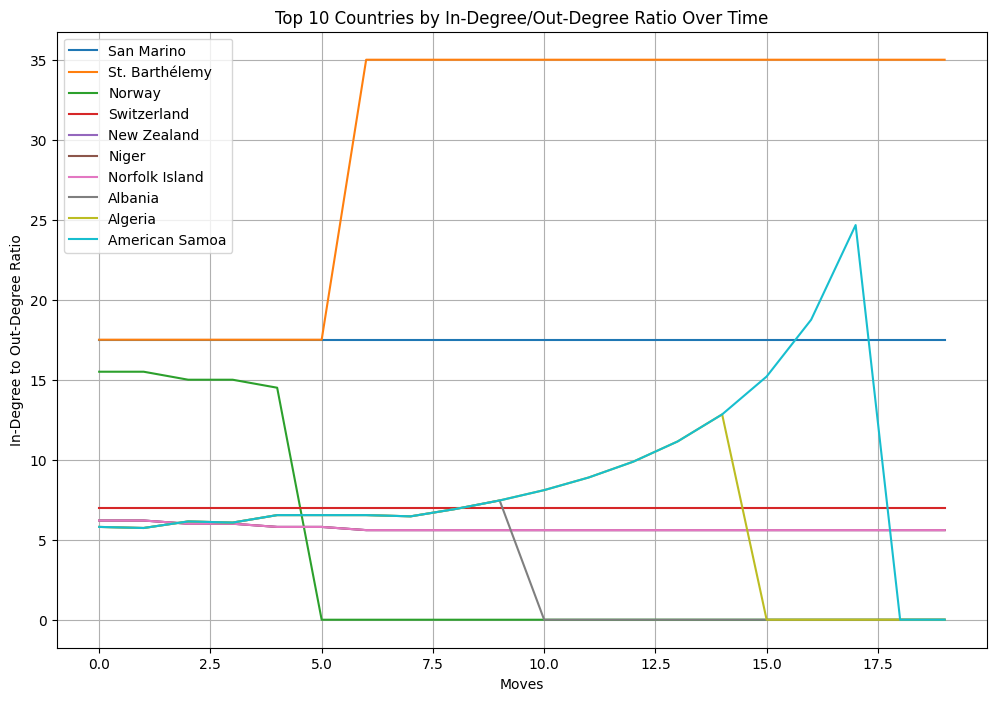

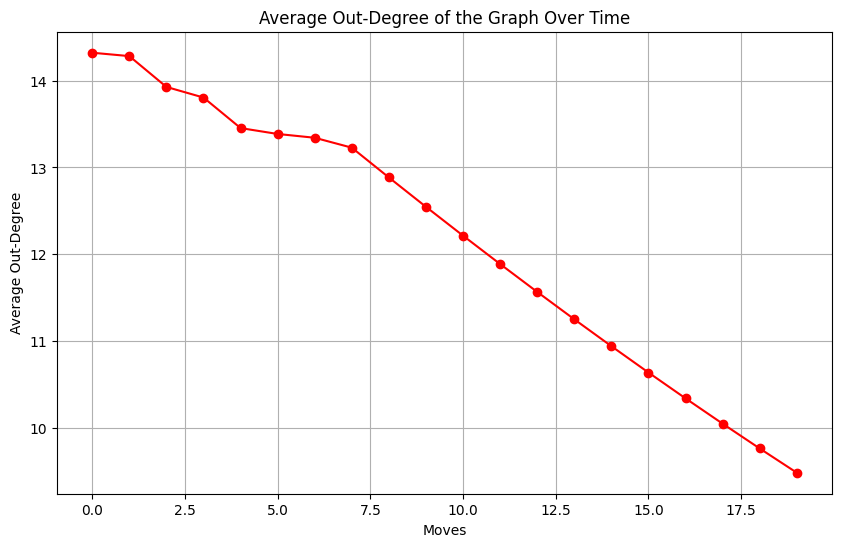

In [4]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import random

# Compute in-degree / (out-degree + 1) ratio
def compute_ratio(graph):
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())
    return {
        node: in_degrees[node] / (out_degrees[node] + 1)
        for node in graph.nodes
    }

def compute_average_outdegree(graph):
    # Sum the out-degrees, then divide by number of nodes
    out_deg_dict = dict(graph.out_degree())
    if len(out_deg_dict) == 0:
        return 0
    total_out = sum(out_deg_dict.values())
    return total_out / len(out_deg_dict)

def simulate_game_and_track_ratio(
    graph, 
    start_country, 
    n_moves=100, 
    sample_interval=10
):
    # Work on a copy so we don't alter the original
    current_graph = graph.copy()
    current_country = start_country

    # Store ratio snapshots: move_count -> { node: ratio }
    tracked_ratios = {}
    # Store average outdegree snapshots: move_count -> float
    average_outdegree_history = {}

    # Sample at move=0
    tracked_ratios[0] = compute_ratio(current_graph)
    average_outdegree_history[0] = compute_average_outdegree(current_graph)

    for move in range(1, n_moves + 1):
        # If the current node is not in the graph, stop
        if current_country not in current_graph.nodes:
            break

        # Get successors
        successors = list(current_graph.successors(current_country))
        if not successors:
            # No moves left, game ends
            break

        # Pick a random successor
        next_country = random.choice(successors)

        # Remove the current node to disallow reuse
        current_graph.remove_node(current_country)

        # Advance
        current_country = next_country

        # Sample if we hit the interval or final move
        if move % sample_interval == 0 or move == n_moves:
            tracked_ratios[move] = compute_ratio(current_graph)
            average_outdegree_history[move] = compute_average_outdegree(current_graph)

    return tracked_ratios, average_outdegree_history

# ----------------------------------------------------------------------------
# Example usage of the above simulation, integrated with existing code
# ----------------------------------------------------------------------------
# Suppose you already have your graph "G" constructed

start_country = 'India'  # Example start country
n_moves = 100
sample_interval = 1

tracked_ratios, avg_outdeg_data = simulate_game_and_track_ratio(
    G, start_country, n_moves=n_moves, sample_interval=sample_interval
)

# Get top 5 countries from initial ratio
initial_ratios = compute_ratio(G)
top_5_countries = sorted(initial_ratios, key=initial_ratios.get, reverse=True)[:10]

# Convert dictionary keys to a sorted list for plotting
time_steps_ratios = sorted(tracked_ratios.keys())
time_steps_outdeg = sorted(avg_outdeg_data.keys())

# Plot ratio changes for top 5 countries
plt.figure(figsize=(12, 8))
for country in top_5_countries:
    y_vals = [tracked_ratios[t].get(country, 0) for t in time_steps_ratios]
    plt.plot(time_steps_ratios, y_vals, label=country)

plt.xlabel('Moves')
plt.ylabel('In-Degree to Out-Degree Ratio')
plt.title('Top 10 Countries by In-Degree/Out-Degree Ratio Over Time')
plt.legend()
plt.grid()
plt.show()

# Plot average outdegree over time
plt.figure(figsize=(10, 6))
avg_y_vals = [avg_outdeg_data[t] for t in time_steps_outdeg]
plt.plot(time_steps_outdeg, avg_y_vals, marker='o', color='red')
plt.xlabel('Moves')
plt.ylabel('Average Out-Degree')
plt.title('Average Out-Degree of the Graph Over Time')
plt.grid()
plt.show()

# Print tracked results
# print("Tracked ratios over time for top 5 countries:")
# for move_count in time_steps_ratios:
#     ratio_dict = {
#         c: tracked_ratios[move_count].get(c, 'N/A') 
#         for c in top_5_countries
#     }
#     print(f"After {move_count} moves: {ratio_dict}")

# print("\nAverage Out-Degree over time:")
# for move_count in time_steps_outdeg:
#     print(f"After {move_count} moves: {avg_outdeg_data[move_count]}")

### An Observation
- The reason for the consistent spike in the countries whose names start and end with the same letter is due to the fact that when it comes to the countries with the higher indegree/outdegree ratio (say, a/b), the ratio a/b is greater than 1. This in turn implies that (a-b)/(b-1) > a/b, leading to an increase in the ratio as the game progresses.

# Strongly Connected Components

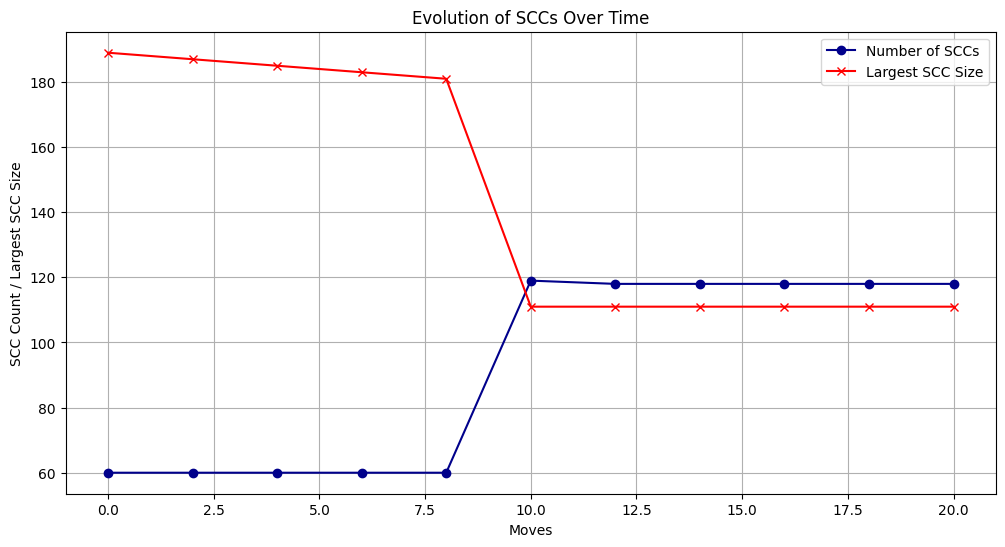


Strategic Insights:
1. A decreasing number of SCCs indicates a collapsing graph, limiting future moves.
2. A shrinking largest SCC size suggests increasing isolation and strategic trapping opportunities.
3. If SCC count remains stable, opportunities for flexible movement persist.


In [65]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Function to compute and analyze SCCs
def analyze_scc(graph):
    sccs = list(nx.strongly_connected_components(graph))
    scc_count = len(sccs)
    scc_sizes = sorted([len(scc) for scc in sccs], reverse=True)
    
    # print(f"Number of SCCs: {scc_count}")
    # print(f"SCC Sizes: {scc_sizes}")
    return scc_count, scc_sizes

# Function to simulate the game and analyze SCC evolution
def simulate_game_scc(graph, start_country, n_moves=100, sample_points=50):
    current_graph = graph.copy()
    visited = set()
    current_country = start_country
    sample_intervals = n_moves // sample_points
    scc_evolution = {}

    for move in range(n_moves):
        if current_country not in current_graph:
            break  # If the node was removed, break out of the loop

        successors = list(current_graph.successors(current_country))
        if not successors:
            break  # No more moves possible

        next_country = random.choice(successors)
        visited.add(current_country)

        # Remove current node only if it exists
        if current_country in current_graph:
            current_graph.remove_node(current_country)

        current_country = next_country

        if move % sample_intervals == 0 or move == n_moves - 1:
            scc_count, scc_sizes = analyze_scc(current_graph)
            scc_evolution[move] = (scc_count, scc_sizes)
    
    return scc_evolution

# Initial SCC analysis
# print("Initial SCC analysis at t=0")
scc_count_t0, scc_sizes_t0 = analyze_scc(G)

# Run a random simulation and analyze SCC evolution
start_country = random.choice(list(G.nodes))
scc_evolution = simulate_game_scc(G, start_country, n_moves=100)

# Plot SCC evolution
moves = list(scc_evolution.keys())
num_sccs = [data[0] for data in scc_evolution.values()]
largest_scc_sizes = [data[1][0] if data[1] else 0 for data in scc_evolution.values()]

plt.figure(figsize=(12, 6))
plt.plot(moves, num_sccs, marker='o', linestyle='-', color='darkblue', label='Number of SCCs')
plt.plot(moves, largest_scc_sizes, marker='x', linestyle='-', color='red', label='Largest SCC Size')
plt.xlabel('Moves')
plt.ylabel('SCC Count / Largest SCC Size')
plt.title('Evolution of SCCs Over Time')
plt.legend()
plt.grid()
plt.show()

# Insights
def generate_scc_insights(scc_count_t0, scc_evolution):
    print("\nStrategic Insights:")
    print("1. A decreasing number of SCCs indicates a collapsing graph, limiting future moves.")
    print("2. A shrinking largest SCC size suggests increasing isolation and strategic trapping opportunities.")
    print("3. If SCC count remains stable, opportunities for flexible movement persist.")

generate_scc_insights(scc_count_t0, scc_evolution)
